# Tutorial 4 - Mouse hippocampus (Spatial MALDI-Visium)

In [1]:
import os
import torch
import scanpy as sc
import importlib
import numpy as np

In [ ]:
from COSIE.data_preprocessing import load_data
from COSIE.utils import setup_seed
from COSIE.configure import get_default_config
from COSIE.COSIE_framework import COSIE_model
from COSIE.downstream_analysis import *

config = get_default_config()
setup_seed(config['training']['seed'])


## Load data

In [3]:
file_path = '../../../project/SpatialMultimodal/datasets/Mouse_hippocampus'

In [4]:
adata1_meta = sc.read_h5ad(os.path.join(file_path,'section3/adata_section3_meta.h5ad'))
adata1_rna = sc.read_h5ad(os.path.join(file_path,'section3/adata_section3_rna.h5ad'))
adata2_meta = sc.read_h5ad(os.path.join(file_path,'section2/adata_section2_meta.h5ad'))

In [5]:
adata1_meta, adata1_rna, adata2_meta

(AnnData object with n_obs × n_vars = 36462 × 1548
     obsm: 'UNI_feature', 'spatial', 'spatial2',
 AnnData object with n_obs × n_vars = 36462 × 1999
     obsm: 'UNI_feature', 'spatial', 'spatial2',
 AnnData object with n_obs × n_vars = 30769 × 1548
     obsm: 'UNI_feature', 'spatial', 'spatial2')

In [6]:
adata1_he = sc.AnnData(X=adata1_meta.obsm['UNI_feature'])
adata2_he = sc.AnnData(X=adata2_meta.obsm['UNI_feature'])

In [7]:
adata1_he.obsm['spatial'] = adata1_meta.obsm['spatial'].copy()
adata2_he.obsm['spatial'] = adata2_meta.obsm['spatial'].copy()


## Define the dictionary structure for input data

Each column denotes one section and None represents that the modality is missing in that section.

In [8]:
data_dict = {
        'RNA': [adata1_rna, None],
        'HE': [adata1_he, adata2_he],
        'Metabolite': [adata1_meta, adata2_meta],
    }

In [9]:
feature_dict, spatial_loc_dict, data_dict_processed = load_data(data_dict, n_comps=50, hvg_num=None)

-------- Processing shared modality HE across sections --------
Running Harmony for HE


2025-05-28 18:28:11,600 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-05-28 18:28:22,990 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-05-28 18:28:23,714 - harmonypy - INFO - Iteration 1 of 10
2025-05-28 18:28:51,643 - harmonypy - INFO - Iteration 2 of 10
2025-05-28 18:29:20,843 - harmonypy - INFO - Iteration 3 of 10
2025-05-28 18:29:50,358 - harmonypy - INFO - Converged after 3 iterations


-------- Processing shared modality Metabolite across sections --------


2025-05-28 18:30:19,204 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...


Running Harmony for Metabolite


2025-05-28 18:30:25,385 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-05-28 18:30:26,153 - harmonypy - INFO - Iteration 1 of 10
2025-05-28 18:30:56,506 - harmonypy - INFO - Iteration 2 of 10
2025-05-28 18:31:29,492 - harmonypy - INFO - Iteration 3 of 10
2025-05-28 18:31:59,917 - harmonypy - INFO - Iteration 4 of 10
2025-05-28 18:32:30,537 - harmonypy - INFO - Iteration 5 of 10
2025-05-28 18:33:00,088 - harmonypy - INFO - Iteration 6 of 10
2025-05-28 18:33:33,601 - harmonypy - INFO - Iteration 7 of 10
2025-05-28 18:34:03,231 - harmonypy - INFO - Iteration 8 of 10
2025-05-28 18:34:21,609 - harmonypy - INFO - Iteration 9 of 10
2025-05-28 18:34:43,473 - harmonypy - INFO - Iteration 10 of 10
2025-05-28 18:34:57,451 - harmonypy - INFO - Converged after 10 iterations


-------- Processing unique modality RNA for section 1 --------
Extracting spatial location for section 1
Extracting spatial location for section 2


In [10]:
data_dict_processed

{'RNA': [AnnData object with n_obs × n_vars = 36462 × 1999
      obsm: 'UNI_feature', 'spatial', 'spatial2', 'RNA_pca',
  None],
 'HE': [AnnData object with n_obs × n_vars = 36462 × 2048
      obsm: 'spatial', 'HE_harmony',
  AnnData object with n_obs × n_vars = 30769 × 2048
      obsm: 'spatial', 'HE_harmony'],
 'Metabolite': [AnnData object with n_obs × n_vars = 36462 × 1548
      obsm: 'UNI_feature', 'spatial', 'spatial2', 'Metabolite_harmony',
  AnnData object with n_obs × n_vars = 30769 × 1548
      obsm: 'UNI_feature', 'spatial', 'spatial2', 'Metabolite_harmony']}

## Specify the linkage indicator

COSIE requires a indicator dictionary to specify the cross-section linkage used during training.

In [11]:
Linkage_indicator = {
        ('s1', 's2'): [('Metabolite', 'Metabolite')]
    }

## Define COSIE Model and Perform Integration

After training, embeddings will be saved to `file_path` in `.npy` format.

In [12]:
model = COSIE_model(config, feature_dict)
optimizer = torch.optim.Adam(model.parameters(), lr=config['training']['lr'])
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

All modalities: ['HE', 'Metabolite', 'RNA']
-------- Encoder description --------
Encoder [HE]: Input 50 → Hidden [256, 128]
Encoder [Metabolite]: Input 50 → Hidden [256, 128]
Encoder [RNA]: Input 50 → Hidden [256, 128]
-------- Dual prediction module description --------
Predictor [HE → Metabolite]: [128, 512, 512, 128]
Predictor [Metabolite → HE]: [128, 512, 512, 128]
Predictor [HE → RNA]: [128, 512, 512, 128]
Predictor [RNA → HE]: [128, 512, 512, 128]
Predictor [Metabolite → RNA]: [128, 512, 512, 128]
Predictor [RNA → Metabolite]: [128, 512, 512, 128]
Using device: cuda:0


In [13]:
final_embeddings = model.train_model(file_path, config, optimizer, device, feature_dict, spatial_loc_dict, 
                                     data_dict_processed, Linkage_indicator)

-------- Running Full-graph training mode --------
Computing linkage between Metabolite (s1) and Metabolite (s2)
Model moved to cuda:0!
-------- Construction of input graphs --------
-------- Constructing spatial graph for s1 --------
Constructing feature graph for [s1 - HE]...
Constructing feature graph for [s1 - Metabolite]...
Constructing feature graph for [s1 - RNA]...
-------- Constructing spatial graph for s2 --------
Constructing feature graph for [s2 - HE]...
Constructing feature graph for [s2 - Metabolite]...
Training started!


Training Epochs: 100%|████████████████████████████████████████████████████████████████| 600/600 [03:09<00:00,  3.16it/s]


Running Evaluation...
Missing modality [RNA] in Section [s2]
Using predictor [HE → RNA] to recover missing embedding...
Using predictor [Metabolite → RNA] to recover missing embedding...
All embeddings have been saved to ../../../project/SpatialMultimodal/datasets/Mouse_hippocampus


## Perform clustering and visualization

Perform joint clustering...


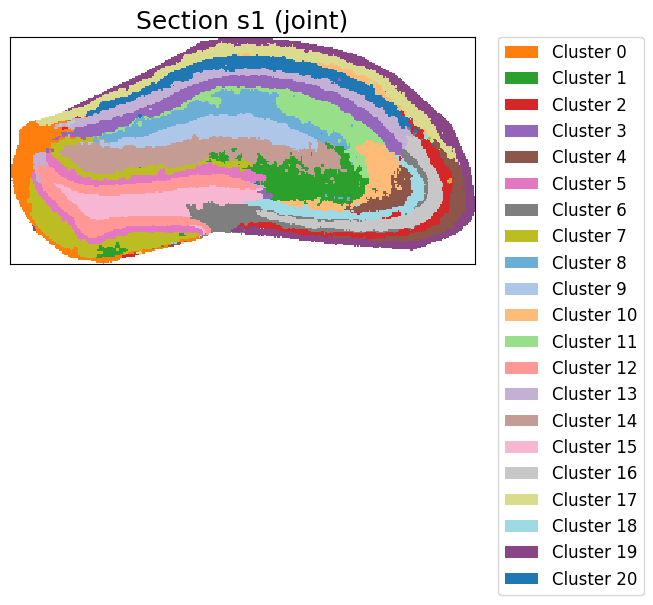

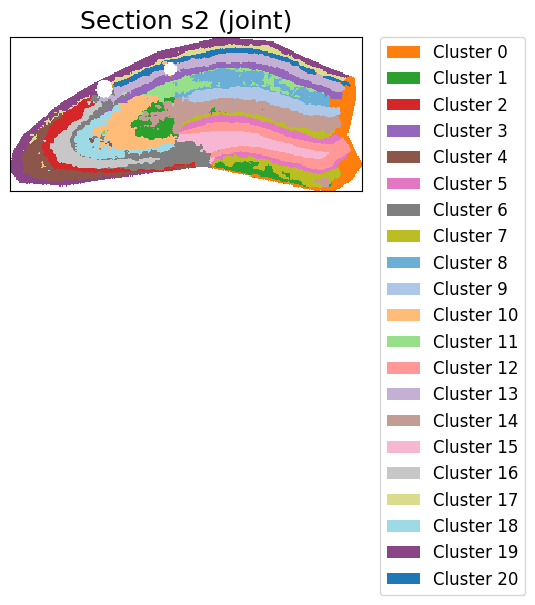

In [15]:
color_map =  [[255,127,14],[44,160,44],[214,39,40],[148,103,189],
              [140,86,75],[227,119,194],[127,127,127],[188,189,34],
             [107,174,214] ,[174,199,232],[255,187,120],[152,223,138],
              [255,152,150],[197,176,213],[196,156,148],[247,182,210],
              [199,199,199],[219,219,141],[158,218,229], [137,69,133],
              [31, 119, 180],[135, 206, 250]]

cluster_label = cluster_and_visualize_superpixel(final_embeddings, 
                                                 data_dict,
                                                 n_clusters=21,
                                                 mode="joint", 
                                                 vis_basis="spatial",  
                                                 colormap = color_map, 
                                                 offset = True,
                                                 swap_xy=True, 
                                                 invert_x=True,
                                                 dpi = 500,
                                                 figscale = 50)

## Predict RNA for Section2

In [16]:
adata2_rna_predicted = perform_prediction(data_dict,
    final_embeddings,
    target_section = 's2',
    target_modality = 'RNA',
    K_num=50,
    target_molecules='All',
    )

Using modality [HE] in section [s2] as spatial/obs reference
[RNA] exists in ['s1'], which will be used as source data section


In [17]:
adata2_rna = sc.read_h5ad(os.path.join(file_path,'section2/adata_section2_rna.h5ad'))

In [18]:
adata2_rna_predicted_norm = create_normalized_adata(adata2_rna_predicted)
adata2_rna_norm = create_normalized_adata(adata2_rna)

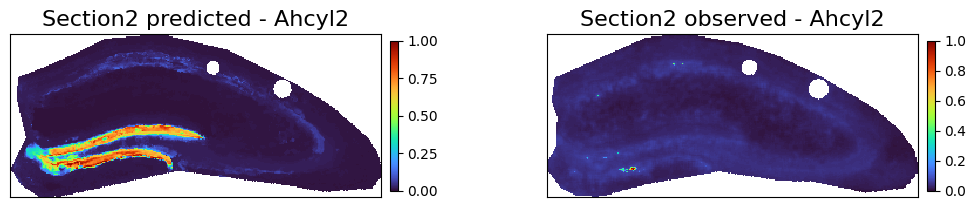

In [19]:
chosed_gene = 'Ahcyl2'
plot_marker_comparison_superpixel(chosed_gene, 
                       adata2_rna_predicted_norm, 
                       adata2_rna_norm, 
                       'Section2 predicted', 
                       'Section2 observed',
                        offset = True,
                        swap_xy = True,
                        figscale = 50)